![](https://www.haskell.org/img/haskell-logo.svg)

IHaskell Notebook
===
Hello, and welcome to the **IHaskell Notebook**. IHaskell Notebook is similar to an interactive shell along the lines of GHCi. However, it is much more powerful, and provides features such as syntax highlighting, autocompletion, multi-line input cells, integrated documentation, rich output visualization, and more. In this notebook, I'd like to demonstrate many of the awesome features IHaskell provides.

IHaskell is implemented as a language kernel for the [Jupyter](https://jupyter.org) project, which means that although the entire thing is written only in Haskell, we get a beautiful notebook interface practically for free.

We can start with very simple Haskell expressions:

In [1]:
-- First of all, we can evaluate simple expressions.
3 + 5
"Hello, " ++ "World!"

8

"Hello, World!"

As you can see, each input cell get an execution number. The first input cell is labeled `In [1]`. Just like in GHCi, the output of the last executed statement or expression is available via the `it` variable - however, in addition, the output of the $n$th cell is available via the `itN` variable. For example, if we wanted to see what the first cell printed, we can go ahead and output that:

In [2]:
it1

"Hello, World!"

In addition to simple code cells such as the ones you see, you can also have other types of cells. All of this inline text, for instance, is written using Markdown cells, which support the majority of Github markdown syntax. This lets you embed images and formatting and arbitrary HTML interspersed with your Haskell code. In addition, you can export these notebooks into HTML or even as presentations using `reveal.js`. 

Alright, back to code. Let's do something slightly fancier:

In [3]:
-- Unlike in GHCi, we can have multi-line expressions.
concat [
  "Hello",
  ", ",
  "World!"
  ] :: String

"Hello, World!"

In addition to multi-line expressions, IHaskell supports most things that you could put in a standard Haskell file. For example, we can  have function bindings without the `let` that GHCi requires. (As long as you group type signatures and their corresponding declarations together, you can use pattern matching and put signatures on your top-level declarations!)

In [4]:
thing :: String -> Int -> Int
thing "no" _ = 100
thing str int = int + length str

thing "no" 10
thing "ah" 10

100

12

So far we've just looked at pure functions, but nothing is stopping us from doing IO.

In [5]:
print "What's going on?"

"What's going on?"

IHaskell supports most GHC extensions via the `:extension` directive (or any shorthand thereof).

In [6]:
-- We can disable extensions.
:ext NoEmptyDataDecls
data Thing

: 

In [7]:
-- And enable extensions.
:ext EmptyDataDecls
data Thing

Data declarations do pretty much what you expect, and work fine on multiple lines. If a declaration turns out to be not quite what you wanted, you can just go back, edit it, and re-evaluate the code cell.

In [8]:
-- Various data declarations work fine.
data One
     = A String
     | B Int
     deriving Show

print [A "Hello", B 10]

[A "Hello",B 10]

Although this doesn't hold everywhere, we've tried to keep IHaskell relatively similar to GHCi in terms of naming. So, just like in GHCi, you can inspect types with `:type` (or shorthands):

In [9]:
-- We can look at types like in GHCi.
:ty 3 + 3

3 + 3 :: forall a. Num a => a

The same goes for the `:info` command. However, unlike GHCi, which simply prints info, the IHaskell notebook brings up a separate pane.

In [10]:
-- What is the Integral typeclass?
:info Integral

If you're looking at this notebook after it's been exported to HTML, you won't be able to see this interactive pane that pops up after this is evaluated. However, you can disable the interactive pager, and instead just show the output below the cell:

In [11]:
-- Only takes effect on later cells, so stick it in its own cell.
:opt no-pager

In [12]:
:info Integral

class (Real a, Enum a) => Integral a where
  quot :: a -> a -> a
  rem :: a -> a -> a
  div :: a -> a -> a
  mod :: a -> a -> a
  quotRem :: a -> a -> (a, a)
  divMod :: a -> a -> (a, a)
  toInteger :: a -> Integer
  {-# MINIMAL quotRem, toInteger #-}
  	-- Defined in ‘GHC.Real’
instance Integral Word -- Defined in ‘GHC.Real’
instance Integral Integer -- Defined in ‘GHC.Real’
instance Integral Int -- Defined in ‘GHC.Real’

We can now write slightly more complicated scripts.

In [13]:
-- Results are printed as we go, even from a single expression.
import Control.Monad
import Control.Concurrent

forM_ [1..5] $ \x -> do
  print x
  threadDelay $ 200 * 1000

1
2
3
4
5

This is where the similarities with GHCi end, and the particularly shiny features of IHaskell begin.

Although looking at text outputs is often enough, there are many times where we really want a richer output. Suppose we have a custom data type for color:

In [14]:
data Color = Red | Green | Blue

If we were playing around with designing GUI applications, for instance, we might want to actually *see* these colors, instead of just seeing the text "Red", "Green", and "Blue" when we are debugging.

IHaskell lets you define a custom display mechanism for any data type via its `IHaskellDisplay` typeclass. Since you can  use IHaskell in console mode as well as notebook mode, you can provide a list of display outputs for any data type, and the frontend will simply choose the best one. Here's how you would implement a very simple display mechanism for this `Color` data type:

In [15]:
import IHaskell.Display

instance IHaskellDisplay Color where
  display color = return $ Display [html code]
    where
      code = concat ["<div style='font-weight: bold; color:"
                    , css color
                    , "'>Look!</div>"]
      css Red   = "red"
      css Blue  = "blue"
      css Green = "green"

Once we define a custom `display :: a -> IO Display` function, we can simply output a `Color`:

In [16]:
Red
Green
Blue

Look!

Look!

Look!

The `DisplayData` type has several constructors which let you display your data as plain text, HTML, images (SVG, PNG, JPG), or even as LaTeX code.

In order to ship an extension for IHaskell, simply create a package named `ihaskell-thing` with a module named `IHaskell.Display.Thing`. As long as `ihaskell-thing` is installed, IHaskell will detect and use it automatically.

A number of packages already exist, which we can briefly look at.

The `ihaskell-aeson` package adds a display for [Aeson](http://hackage.haskell.org/package/aeson) JSON `Value` types. These are automatically formatted as JSON, rather than as Haskell values:

In [17]:
-- Aeson JSON data types are displayed nicely.
:ext OverloadedStrings

import Data.Aeson

data Coord  = Coord { x :: Double, y :: Double }
instance ToJSON Coord where
   toJSON (Coord x y) = object ["x" .= x, "y" .= y]

Null
Bool True
toJSON (Coord 3 2)

null

true

{
    "x": 3,
    "y": 2
}

In [18]:
-- Turn off SVG output
:option no-svg

The `ihaskell-blaze` package lets you play around with HTML straight from within IHaskell using the [Blaze](http://jaspervdj.be/blaze/tutorial.html) library.

In [19]:
-- Small bits of HTML generated via Blaze are displayed.

import Prelude hiding (div, id)
import Text.Blaze.Html4.Strict hiding (map, style)
import Text.Blaze.Html4.Strict.Attributes

div ! style "color: red" $ do
    p "This is an example of BlazeMarkup syntax."
    b "Hello"
    
forM [1..5] $ \size -> do
  let s = toValue $ size * 70
  img ! src "https://www.google.com/images/srpr/logo11w.png" ! width s

<div style="color: red">
    <p>
        This is an example of BlazeMarkup syntax.
    </p>
    <b>
        Hello
    </b>
</div>

<img src="https://www.google.com/images/srpr/logo11w.png" width="70">
<img src="https://www.google.com/images/srpr/logo11w.png" width="140">
<img src="https://www.google.com/images/srpr/logo11w.png" width="210">
<img src="https://www.google.com/images/srpr/logo11w.png" width="280">
<img src="https://www.google.com/images/srpr/logo11w.png" width="350">

The `ihaskell-diagrams` package allows you to experiment with the [diagrams](http://projects.haskell.org/diagrams/) package. It requires the Cairo backend.

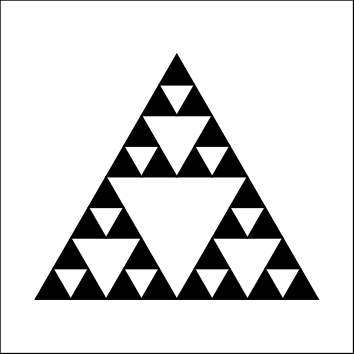

In [20]:
-- We can draw diagrams, right in the notebook.
:extension NoMonomorphismRestriction FlexibleContexts TypeFamilies
import Diagrams.Prelude

-- By Brent Yorgey
-- Draw a Sierpinski triangle!
sierpinski 1 = eqTriangle 1
sierpinski n =     s
                  ===
               (s ||| s) # centerX
  where s = sierpinski (n-1)

-- The `diagram` function is used to display them in the notebook.
diagram $ sierpinski 4
            # centerXY
            # fc black
          `atop` square 10
                   # fc white

Just like with Diagrams, `ihaskell-charts` allows you to use the [Chart](https://github.com/timbod7/haskell-chart/wiki) library for plotting from within IHaskell. (You will need to install `cairo` as well, which may be a bit of a hassle.)

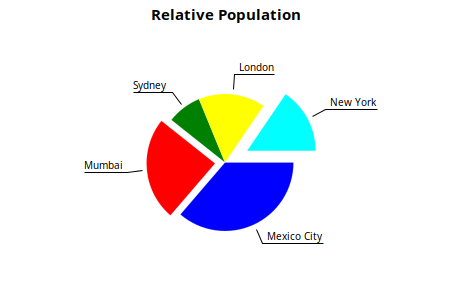

In [21]:
-- We can draw small charts in the notebook.
-- This example is taken from the haskell-chart documentation.
import Graphics.Rendering.Chart 
import Data.Default.Class
import Control.Lens

let values = [
     ("Mexico City"  , 19.2, 0),
     ("Mumbai"       , 12.9, 10), 
     ("Sydney"       , 4.3,  0),
     ("London"       , 8.3,  0), 
     ("New York"     , 8.2,  25)]
     
pitem (s, v, o) = pitem_value .~ v
                $ pitem_label .~ s
                $ pitem_offset .~ o
                $ def  

-- Convert to a renderable in order to display it.
toRenderable 
  $ pie_title .~ "Relative Population"
  $ pie_plot . pie_data .~ map pitem values
  $ def

In addition to displaying outputs in a rich format, IHaskell has a bunch of useful features.

For instance, the popular linting tool `hlint` is integrated and turned on by default. Let's write some ugly code, and see what it tells us:

In [22]:
-- There is also hlint integration enabled by default.
-- If you write sketchy code, it will tell you:
f :: Int -> Int
f x = x + 1

-- Most warnings are orange...
f $ 3

do
  return 3

Line 1: Redundant $
Found:
f $ 3
Why not:
f 3Line 1: Redundant do
Found:
do return 3
Why not:
return 3

4

3

If you're an experienced Haskeller, though, and don't want `hlint` telling you what to do, you can easily turn it off:

In [23]:
-- If hlint annoys you, though, you can turn it off.
-- Note that this only takes effect in the next cell execution.
:opt no-lint

In [24]:
-- You could similarly use `:opt lint` to turn it back on.
f $ 3

4

In addition to `hlint` integration, IHaskell also integrates **Hoogle** for documentation searches. IHaskell provides two directives for searching Hoogle. The first of these, `:document` (or shorthands), looks for exact matches.

In [25]:
:doc filterM

No response available: no matching identifiers found.

The other provided command is `:hoogle`. This does a normal Hoogle search, and thus lets you use imperfect matching and searching by type signature. This will show you documentation for things that match the desired type signature, as demonstrated below. It automatically formats inline Haskell code and hyperlinks the identifiers to their respective Haddock documentations.

In [26]:
:hoogle :: a -> ST s (STRef s a)

<s0>newSTRef</s0> :: a -> ST s (STRef s a)
URL: https://hackage.haskell.org/package/base/docs/Data-STRef.html#v:newSTRef
Build a new <a>STRef</a> in the current state thread

<s0>newSTRef</s0> :: a -> ST s (STRef s a)
URL: https://hackage.haskell.org/package/base/docs/Data-STRef-Lazy.html#v:newSTRef

<s0>newSTRef</s0> :: () => a -> ST s (STRef s a)
URL: https://hackage.haskell.org/package/rebase/docs/Rebase-Prelude.html#v:newSTRef
Build a new <a>STRef</a> in the current state thread

<s0>newSTRef</s0> :: a -> ST s (STRef s a)
URL: https://hackage.haskell.org/package/open-witness/docs/Data-OpenWitness-ST.html#v:newSTRef

If you need a refresher on all of the options, you can just use `:help`:

In [27]:
:help

The following commands are available:
    :extension <Extension>    -  Enable a GHC extension.
    :extension No<Extension>  -  Disable a GHC extension.
    :type <expression>        -  Print expression type.
    :info <name>              -  Print all info for a name.
    :hoogle <query>           -  Search for a query on Hoogle.
    :doc <ident>              -  Get documentation for an identifier via Hogole.
    :set -XFlag -Wall         -  Set an option (like ghci).
    :option <opt>             -  Set an option.
    :option no-<opt>          -  Unset an option.
    :?, :help                 -  Show this help text.

Any prefix of the commands will also suffice, e.g. use :ty for :type.

Options:
  lint        – enable or disable linting.
  svg         – use svg output (cannot be resized).
  show-types  – show types of all bound names
  show-errors – display Show instance missing errors normally.
  pager       – use the pager to display results of :info, :doc, :hoogle, etc.

All of the code you normally put into IHaskell is (like in GHCi) interpreted. However, sometimes you've perfected a function, and now need it to run faster. In that case, you can go ahead and define a module in a single cell. As long as your module has a module header along the lines of `module Name where`, IHaskell will recognize it as a module. It will create the file `A/B.hs`, compile it, and load it. 

In [28]:
-- If your code isn't running fast enough, you can just put it into a module.
module A.B where

fib 0 = 1
fib 1 = 1
fib n = fib (n-1) + fib (n-2)

Note that the module is by default imported unqualified, as though you had typed `import A.B`.

In [29]:
-- The module is automatically imported unqualified.
print $ A.B.fib 20
print $ fib 20

10946

10946

Note that since a new module is imported, all previous bound identifiers are now unbound. For instance, we no longer have access to the `f` function from before:

In [30]:
f 3

: 

However, if you re-import this module with another import statement, the original implicit import goes away.

In [31]:
import qualified A.B as Fib

Fib.fib 20
fib 20

10946

10946

Thanks!
---

That's it for now! I hope you've enjoyed this little demo of **IHaskell**! There are still a few features that I haven't covered, such as the `show-types` and `show-errors` options, as well as the relatively intelligent autocompletion mechanism and inline type info popups.

I hope you find IHaskell useful, and please report any bugs or features requests [on Github](https://github.com/gibiansky/IHaskell/issues). If you have any comments, want to contribute, or just want to get in touch, don't hesitate to contact me at Andrew dot Gibiansky at Gmail. Contributions are also more than welcome, and I'm happy to help you get started with IHaskell development if you'd like to contribute!

Thank you to [Adam Vogt](https://github.com/aavogt), [Stian Håklev](http://reganmian.net/), and [@edechter](https://github.com/edechter) for their testing, bug reporting, pull requests, and general patience!